# Generative Adversarial Network (GAN) on Oxford 102 Flowers

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from tqdm.notebook import tqdm

In [78]:
# -----------------------------
# 1. Dataset setup
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # scale to [-1,1]
    transforms.Normalize([0.5], [0.5])  # scale to [-1,1]
])

# train_dataset = datasets.Flowers102(root='./data', split="train", transform=transform, download=True)
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# test_dataset = datasets.Flowers102(root='./data', split="test", transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoaders allow iteration in mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

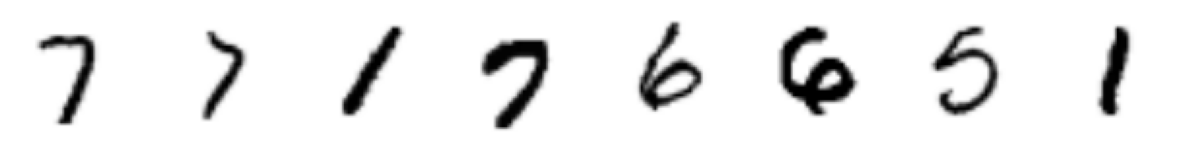

In [79]:
# -----------------------------
# 4. Visualize some training images
# -----------------------------

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

def plot_examples(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15,3))
    for idx, ax in enumerate(axes):
        image = (images[idx].squeeze() + 1) / 2
        ax.imshow(image, cmap='Greys')
        ax.axis('off')
    plt.show()

# Show images
plot_examples(images[:8])

In [80]:
# -----------------------------
# 3. Define Generator and Discriminator
# -----------------------------
latent_dim = 100
img_shape = (3, 64, 64)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 64 // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 256 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # First block (no batch norm)
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Second block
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, momentum=0.8),

            # Third block
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, momentum=0.8),

            # Fourth block
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, momentum=0.8),
        )

        # Downsampled image size after 4 strided convs
        ds_size = 64 // 2 ** 4
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity

In [81]:
# -----------------------------
# 4. Instantiate models, optimizers, loss
# -----------------------------

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)

# Initialize weights
G.apply(weights_init_normal)
D.apply(weights_init_normal)

print(device)

cuda


In [82]:
criterion = nn.BCELoss()
lr = 0.0002
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [83]:
# -----------------------------
# 5. Training loop with test loss
# -----------------------------
epochs = 20
G_losses, D_losses, D_test_losses = [], [], []

for epoch in tqdm(range(epochs)):
    for real_images, _ in train_loader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # -----------------------------
        # Train Discriminator
        # -----------------------------
        D.zero_grad()
        outputs_real = D(real_images)
        loss_real = criterion(outputs_real, real_labels)

        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = G(noise)
        outputs_fake = D(fake_images.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        # -----------------------------
        # Train Generator
        # -----------------------------
        G.zero_grad()
        outputs = D(fake_images)
        loss_G = criterion(outputs, real_labels)
        loss_G.backward()
        optimizerG.step()

    # Track losses
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

    # Compute discriminator loss on test set
    # D.eval()
    # test_loss = 0.0
    # with torch.no_grad():
    #     for test_images, _ in tqdm(test_loader):
    #         test_images = test_images.to(device)
    #         batch_size_test = test_images.size(0)
    #         test_labels = torch.ones(batch_size_test, 1).to(device)
    #         outputs_test = D(test_images)
    #         test_loss += criterion(outputs_test, test_labels).item()
    # D_test_losses.append(test_loss / len(test_loader))
    # D.train()

    # print(f"Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}, Val D Loss: {D_test_losses[-1]:.4f}")
    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] Loss D: 1.2442, Loss G: 1.1393
Epoch [2/20] Loss D: 1.3992, Loss G: 0.6044
Epoch [3/20] Loss D: 0.8940, Loss G: 2.3232
Epoch [4/20] Loss D: 0.4403, Loss G: 4.1312
Epoch [5/20] Loss D: 0.2648, Loss G: 1.5298
Epoch [6/20] Loss D: 0.1537, Loss G: 1.9142
Epoch [7/20] Loss D: 0.2630, Loss G: 1.1436
Epoch [8/20] Loss D: 0.1607, Loss G: 3.7388
Epoch [9/20] Loss D: 0.0717, Loss G: 6.1184
Epoch [10/20] Loss D: 0.2460, Loss G: 4.4747
Epoch [11/20] Loss D: 0.0714, Loss G: 4.6593
Epoch [12/20] Loss D: 0.0457, Loss G: 2.4375
Epoch [13/20] Loss D: 0.0231, Loss G: 7.5589
Epoch [14/20] Loss D: 0.0065, Loss G: 6.2993
Epoch [15/20] Loss D: 0.0237, Loss G: 4.6664
Epoch [16/20] Loss D: 0.1628, Loss G: 4.1289
Epoch [17/20] Loss D: 0.9584, Loss G: 7.9165
Epoch [18/20] Loss D: 1.7232, Loss G: 2.5755
Epoch [19/20] Loss D: 0.0762, Loss G: 8.3048
Epoch [20/20] Loss D: 0.0647, Loss G: 3.8736


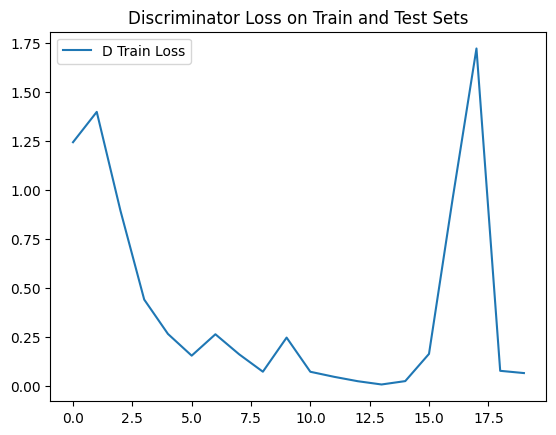

In [84]:
# -----------------------------
# 6. Plot discriminator loss
# -----------------------------
plt.figure()
plt.plot(D_losses, label="D Train Loss")
# plt.plot(D_test_losses, label="D Test Loss")
plt.legend()
plt.title("Discriminator Loss on Train and Test Sets")
plt.show()

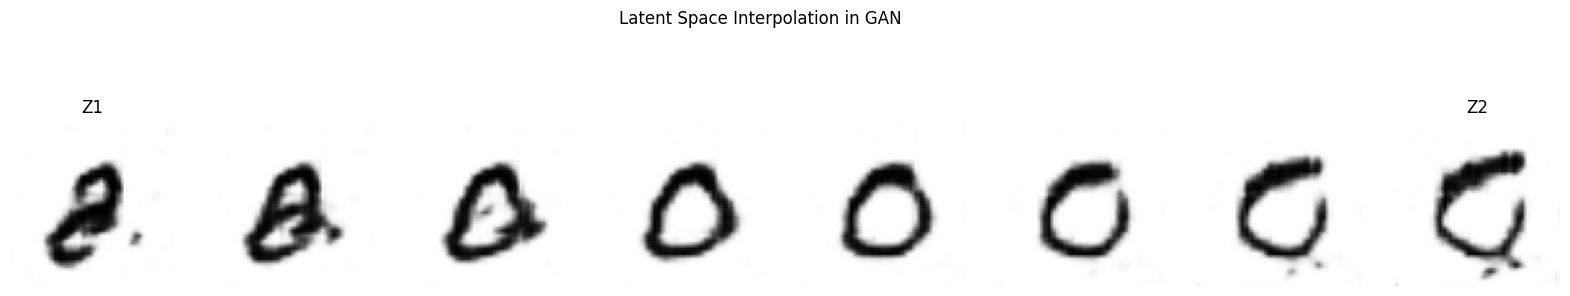

In [85]:
# -----------------------------
# 7. Latent space interpolation
# -----------------------------
z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)

steps = 6
interpolated = [(1-alpha)*z1 + alpha*z2 for alpha in np.linspace(0,1,steps+2)[1:-1]]

with torch.no_grad():
    G.eval()

    reconstructions = [G(z).cpu() for z in interpolated]

    fig, axes = plt.subplots(1, steps+2, figsize=(20,4))
    # Left original
    axes[0].imshow(np.transpose((G(z1).cpu()[0]+1)/2, (1,2,0)), cmap='Greys')
    axes[0].set_title("Z1")
    axes[0].axis('off')
    # Interpolations
    for i in range(steps):
        axes[i+1].imshow(np.transpose((reconstructions[i][0]+1)/2, (1,2,0)), cmap='Greys')
        axes[i+1].axis('off')
    # Right original
    axes[-1].imshow(np.transpose((G(z2).cpu()[0]+1)/2, (1,2,0)), cmap='Greys')
    axes[-1].set_title("Z2")
    axes[-1].axis('off')
    plt.suptitle("Latent Space Interpolation in GAN")
    plt.show()